TODO:

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
import seaborn as sns
from tqdm.notebook import tqdm
from tqdm import trange

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets, transforms
from torchvision.datasets import FashionMNIST

from boring_utils.utils import *

%matplotlib inline 
init_graph()
device = get_device()
set_seed(42, strict=True)

In [2]:
DATASET_PATH = "../data"
CHECKPOINT_PATH = "../model/optm_func/"
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

In [3]:
# https://pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html
# transforms.Normalize(mean, std)
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,))
])

transform_b = transforms.Compose([
                transforms.ToTensor(),
])

train_set = FashionMNIST(
    root=DATASET_PATH, 
    train=True, 
    download=True, 
    transform=transform
)

test_set = FashionMNIST(
    root=DATASET_PATH, 
    train=False, 
    download=True, 
    transform=transform
)

train_set, val_set = torch.utils.data.random_split(train_set, [50000, 10000])

train_loader = DataLoader(
    train_set, batch_size=1024, shuffle=True, drop_last=False)

val_loader = DataLoader(
    val_set, batch_size=1024, shuffle=True, drop_last=False)

test_loader = DataLoader(
    test_set, batch_size=1024, shuffle=True, drop_last=False)

In [4]:
test_set_no_trans = FashionMNIST(
    root=DATASET_PATH, 
    train=False, 
    download=True, 
    transform=transform_b
)

test_loader_no_trans = DataLoader(
    test_set_no_trans, batch_size=1024, shuffle=True, drop_last=False)

Batch Preview

In [5]:
def print_data(dataset, data_loader):
    # raw data, untransformed
    cprint((dataset.data.float() / 255.0).mean().item())
    cprint((dataset.data.float() / 255.0).std().item())

    # transformed data
    imgs, _ = next(iter(data_loader))
    cprint(imgs.mean().item(), imgs.std().item())
    cprint(imgs.max().item(), imgs.min().item())

In [6]:
print_data(test_set, test_loader)

print_data -> (dataset.data.float() / 255.0).mean().item():
0.2868492603302002
print_data -> (dataset.data.float() / 255.0).std().item():
0.3524441719055176
print_data -> imgs.mean().item():
-0.4231258034706116
print_data -> imgs.std().item():
0.7069889307022095
print_data -> imgs.max().item():
1.0
print_data -> imgs.min().item():
-1.0


In [7]:
print_data(test_set_no_trans, test_loader_no_trans)

print_data -> (dataset.data.float() / 255.0).mean().item():
0.2868492603302002
print_data -> (dataset.data.float() / 255.0).std().item():
0.3524441719055176
print_data -> imgs.mean().item():
0.2812195122241974
print_data -> imgs.std().item():
0.34957683086395264
print_data -> imgs.max().item():
1.0
print_data -> imgs.min().item():
0.0


Define activation functions

In [8]:
act_fn_by_name = {}

class Tanh(nn.Module):
    '''
    https://pytorch.org/docs/master/generated/torch.nn.Tanh.html#torch.nn.Tanh
    '''
    def forward(self, x):
        return (torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x))

act_fn_by_name['tanh'] = Tanh


class ReLU(nn.Module):
    '''
    https://pytorch.org/docs/master/generated/torch.nn.ReLU.html#torch.nn.ReLU
    '''
    def forward(self, x):
        # return torch.max(0, x)
        return x * (x > 0).float()

act_fn_by_name['relu'] = ReLU


class LeakyReLU(nn.Module):
    '''
    https://pytorch.org/docs/master/generated/torch.nn.LeakyReLU.html#torch.nn.LeakyReLU
    '''
    def __init__(self, negative_slope=0.1):
        super().__init__()
        self.neg_slop = negative_slope
        
    def forward(self, x):
        return torch.where(x > 0, x, self.neg_slop * x)

act_fn_by_name['leakyrelu'] = LeakyReLU


class Identity(nn.Module):
    def forward(self, x):
        return x

act_fn_by_name['identity'] = Identity

# Plot Functions

## vis grad

In [9]:
# from t3
def vis_gradients(
        net, color="C0", print_variance=False, 
        small_loader = DataLoader(train_set, batch_size=256, shuffle=False)
    ):
    """
    Inputs:
        net - Object of class BaseNetwork
        color - Color in which we want to visualize the histogram (for easier separation of activation functions)
    
    Use cross entropy loss for the first batch of the training set to calculate the gradients of the weights.
    """
    
    net.eval()
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)
    
    # Pass one batch through the network, and calculate the gradients for the weights
    net.zero_grad()
    preds = net(imgs)
    loss = F.cross_entropy(preds, labels)
    loss.backward()
    # We limit our visualization to the weight parameters and exclude the bias to reduce the number of plots
    grads = {name: params.grad.data.view(-1).cpu().clone().numpy() for name, params in net.named_parameters() if "weight" in name}
    net.zero_grad()
    
    # Plotting
    columns = len(grads)
    fig, ax = plt.subplots(1, columns, figsize=(columns*3.5, 2.5))
    fig_index = 0
    for key in grads:
        key_ax = ax[fig_index % columns]
        sns.histplot(
            data=grads[key], bins=30, ax=key_ax, color=color, kde=True)
        key_ax.set_title(str(key), fontsize=16)
        key_ax.set_xlabel("Grad magnitude")
        # key_ax.set_xticklabels(key_ax.get_xticklabels(), rotation=30)
        fig_index += 1

    fig.suptitle(f"Grad magnitude dist for act func {net.act_fn}", fontsize=24, y=1.2)
    fig.subplots_adjust(wspace=0.8)
    plt.show()
    plt.close() 

    if print_variance:
        for key in sorted(grads.keys()):
            print(f"{key} - Variance: {np.var(grads[key])}")


## plot dist from dict

In [10]:
def plot_dists(val_dict, color="C0", xlabel=None, stat="count", use_kde=True):
    columns = len(val_dict)
    fig, ax = plt.subplots(1, columns, figsize=(columns*3.5, 2.5))
    fig_index = 0
    for key in sorted(val_dict.keys()):
        key_ax = ax[fig_index % columns]

        # Only plot kde if there is variance
        sns.histplot(
            val_dict[key], 
            ax=key_ax, 
            color=color, 
            bins=50, 
            stat=stat,
            kde=use_kde and (
                (val_dict[key].max() - val_dict[key].min()
            ) > 1e-8)
        ) 

        key_ax.set_title(
            f"{key} " + (r"(%i $\to$ %i)" % (val_dict[key].shape[1], val_dict[key].shape[0]) \
                if len(val_dict[key].shape) > 1 else ""), fontsize=16)

        if xlabel is not None:
            key_ax.set_xlabel(xlabel)
        fig_index += 1

    fig.subplots_adjust(wspace=0.8)
    return fig

## vis act

In [11]:
def vis_activations(
        model, color="C0", print_variance=False, 
        small_loader=DataLoader(train_set, batch_size=1024, shuffle=False)
    ):
    model.eval()
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)
    
    # Pass one batch through the network, and calculate the gradients for the weights
    feats = imgs.view(imgs.shape[0], -1)
    activations = {}
    with torch.no_grad():
        for layer_index, layer in enumerate(model.layers):
            feats = layer(feats)
            if isinstance(layer, nn.Linear):
                activations[f"Layer {layer_index}"] = feats.view(-1).detach().cpu().numpy()
    
    ## Plotting
    fig = plot_dists(activations, color=color, stat="density", xlabel="Activation vals")
    fig.suptitle("Activation distribution", fontsize=24, y=1.2)
    plt.show()
    plt.close() 
    
    if print_variance:
        for key in sorted(activations.keys()):
            print(f"{key} - Variance: {np.var(activations[key])}")


## vis weigt dist

In [20]:
def vis_weight_distribution(model, color="C0"):
    weights = {}
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            continue
        key_name = f"Layer {name.split('.')[1]}"
        weights[key_name] = param.detach().view(-1).cpu().numpy()
    
    # Plotting
    fig = plot_dists(weights, color=color, xlabel="Weight vals")
    fig.suptitle("Weight distribution", fontsize=24, y=1.2)
    plt.show()
    plt.close() 

# NN

In [13]:
class BaseNN(nn.Module):
    def __init__(self, act_fn, input_size=784, hidden_sizes=[512, 256, 256, 128], num_classes=10):
        super().__init__()
        
        self.act_fn = act_fn
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.num_classes = num_classes

        # Create the network based on the specified hidden sizes
        layers = []
        layer_sizes = [input_size] + hidden_sizes
        for layer_index in range(1, len(layer_sizes)):
            layers += [
                nn.Linear(layer_sizes[layer_index-1], 
                          layer_sizes[layer_index]),
                self.act_fn
                ]
        layers += [nn.Linear(layer_sizes[-1], num_classes)]
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        # reshape img to flat tensor
        # x = x.view(x.size(0), -1)
        x = x.view(-1, self.input_size)
        x = self.layers(x)
        return x
        


In [14]:
_get_file_name = lambda model_path, model_name, extension='.tar': os.path.join(model_path, model_name + extension)


def load_model(model_path, model_name, act_fn, net=None, **kargs):
    """
    Loads a saved model from disk.
    """
    model_file = _get_file_name(model_path, model_name)
    if net is None:
        net = BaseNN(act_fn=act_fn, **kargs)
    net.load_state_dict(torch.load(model_file, map_location=device))
    return net


def save_model(model, model_path, model_name):
    """
    Given a model, we save the state_dict and hyperparameters.
    
    Inputs:
        model - Network object to save parameters from
        model_path - Path of the checkpoint directory
        model_name - Name of the model (str)
    """
    os.makedirs(model_path, exist_ok=True)
    model_file = _get_file_name(model_path, model_name)
    torch.save(model.state_dict(), model_file)


def test_model(net, data_loader):
    """
    Test a model on a specified dataset.
    
    Inputs:
        net - Trained model of type BaseNetwork
        data_loader - DataLoader object of the dataset to test on (validation or test)
    """
    net.eval()
    true_preds, count = 0., 0
    for imgs, labels in data_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        with torch.no_grad():
            preds = net(imgs).argmax(dim=-1)
            true_preds += (preds == labels).sum().item()
            count += labels.shape[0]
    test_acc = true_preds / count
    return test_acc 

# [1] Constant Value Init

When initializing a neural network, there are a few properties we would like to have. 
- First, the variance of the input should be propagated through the model to the last layer, so that we have a similar standard deviation for the output neurons. If the variance would vanish the deeper we go in our model, it becomes much harder to optimize the model as the input to the next layer is basically a single constant value. Similarly, if the variance increases, it is likely to explode (i.e. head to infinity) the deeper we design our model. 
- The second property we look out for in initialization techniques is a gradient distribution with equal variance across layers. If the first layer receives much smaller gradients than the last layer, we will have difficulties in choosing an appropriate learning rate. 

As a starting point for finding a good method, we will analyze different initialization based on our linear neural network with no activation function (i.e. an identity). We do this because initializations depend on the specific activation function used in the network, and we can adjust the initialization schemes later on for our specific choice.

In [15]:
model = BaseNN(act_fn=Identity()).to(device)

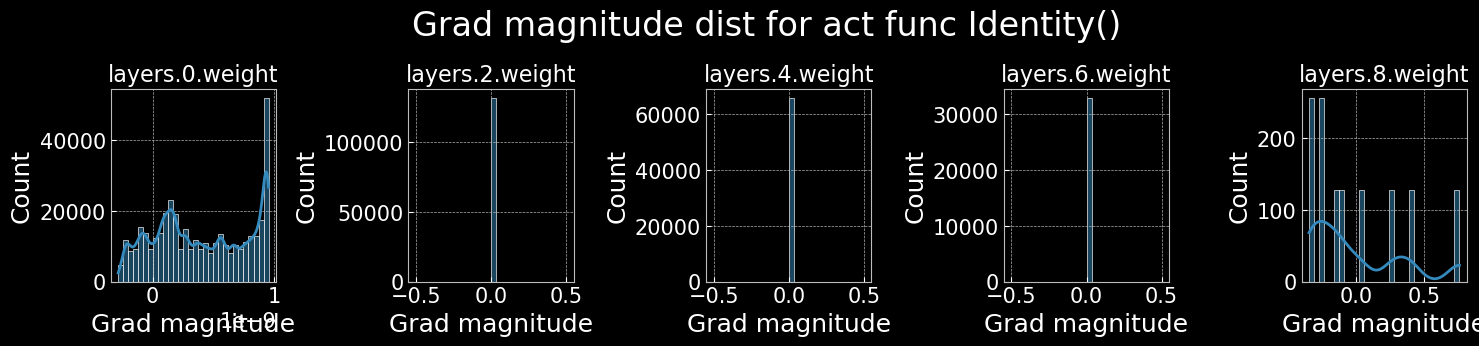

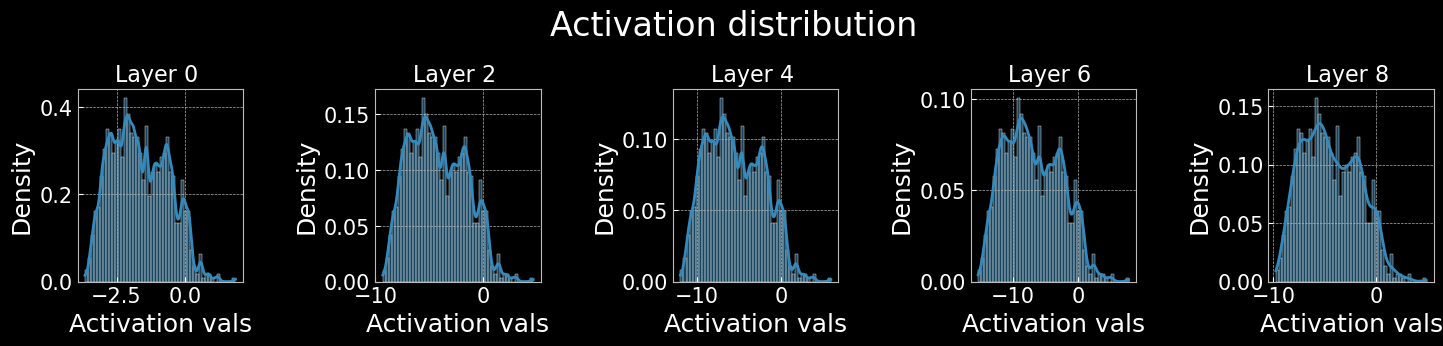

Layer 0 - Variance: 1.0259321928024292
Layer 2 - Variance: 6.723546981811523
Layer 4 - Variance: 11.01585865020752
Layer 6 - Variance: 18.048381805419922
Layer 8 - Variance: 7.39261531829834


In [16]:
def const_init(model, c=0.0):
    for name, param in model.named_parameters():
        param.data.fill_(c)

const_init(model, c=0.005)
vis_gradients(model)
vis_activations(model, print_variance=True)

As we can see, only the first and the last layer have diverse gradient distributions while the other three layers have the same gradient for all weights (note that this value is unequal 0, but often very close to it). 

**Having the same gradient for parameters that have been initialized with the same values means that we will always have the same value for those parameters. This would make our layer useless and reduce our effective number of parameters to 1. Thus, we cannot use a constant initialization to train our networks.**

# [2] Constant Var Init

From the experiment above, we have seen that a constant value is not working. So instead, how about we initialize the parameters by randomly sampling from a distribution like a Gaussian? The most intuitive way would be to choose one variance that is used for all layers in the network. Let's implement it below, and visualize the activation distribution across layers.

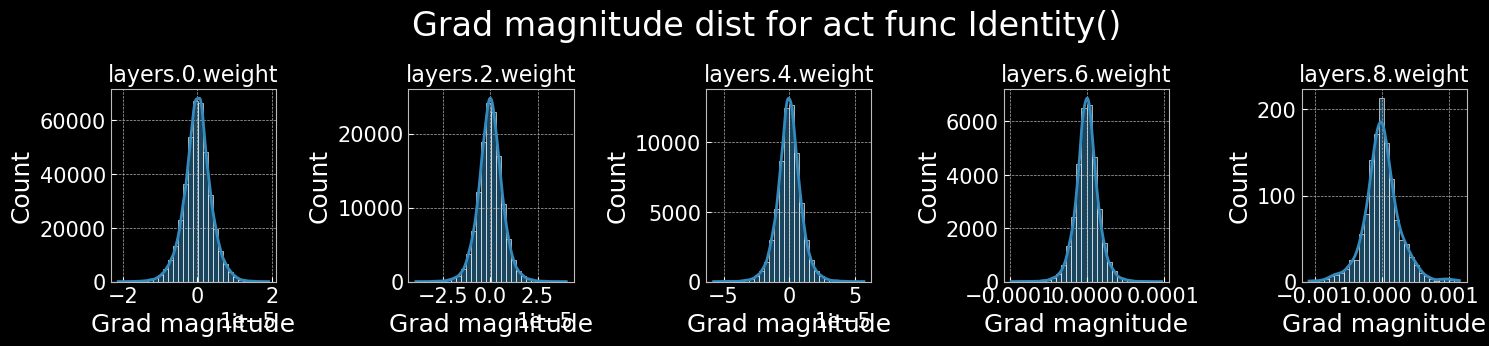

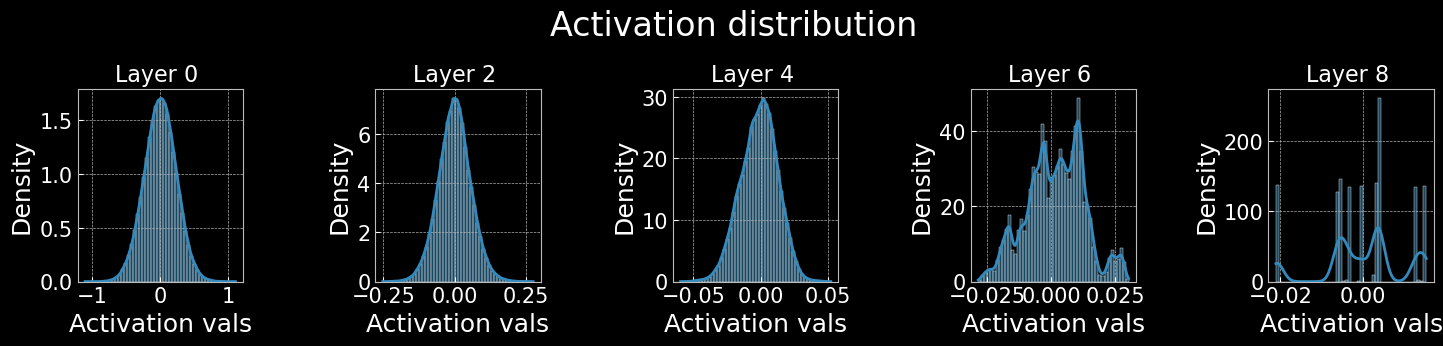

Layer 0 - Variance: 0.054919641464948654
Layer 2 - Variance: 0.003223220119252801
Layer 4 - Variance: 0.00018628058023750782
Layer 6 - Variance: 0.0001254447124665603
Layer 8 - Variance: 9.509174560662359e-05


In [18]:
def var_init(model, std=0.01):
    for name, param in model.named_parameters():
        param.data.normal_(std=std)
        
var_init(model, std=0.01)
vis_gradients(model)
vis_activations(model, print_variance=True)

**The variance of the activation becomes smaller and smaller across layers, and almost vanishes in the last layer.** Alternatively, we could use a higher standard deviation:

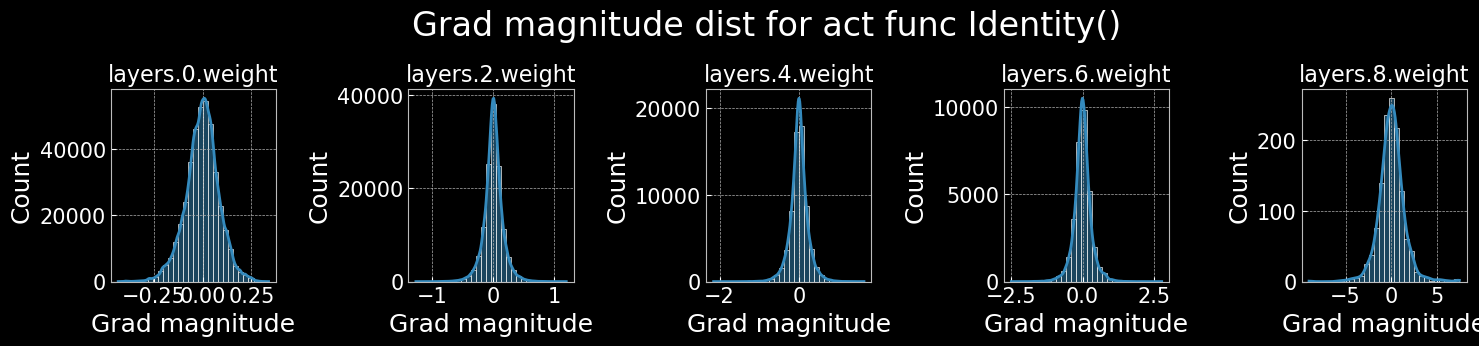

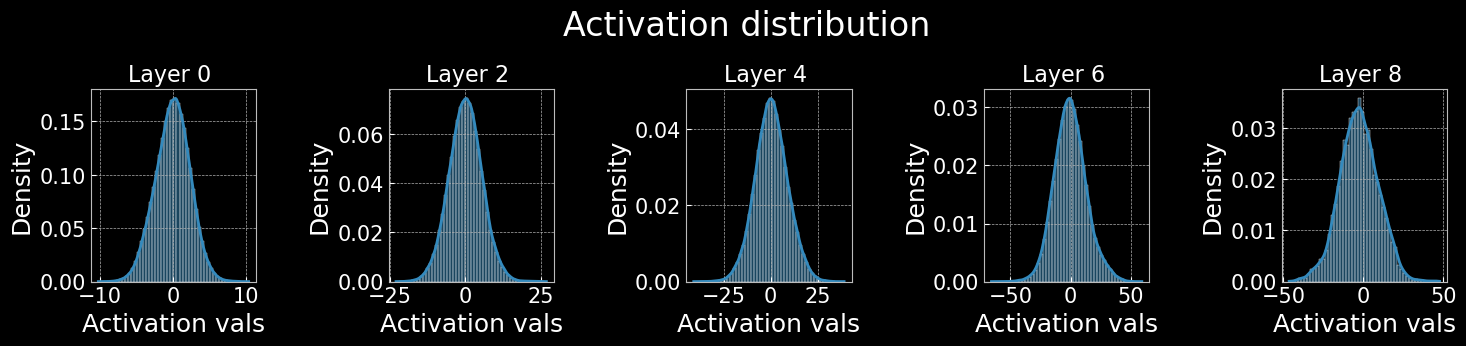

Layer 0 - Variance: 5.564070224761963
Layer 2 - Variance: 29.667041778564453
Layer 4 - Variance: 74.99357604980469
Layer 6 - Variance: 178.24465942382812
Layer 8 - Variance: 146.34042358398438


In [19]:
var_init(model, std=0.1)
vis_gradients(model)
vis_activations(model, print_variance=True)

With a higher standard deviation, the activations are likely to explode. You can play around with the specific standard deviation values, but it will be hard to find one that gives us a good activation distribution across layers and is very specific to our model. 

If we would change the hidden sizes or number of layers, you would have to search all over again, which is neither efficient nor recommended.

# [3] Eq Var Init and How to Find Appropriate Init Values

We state two requirements:
1. The mean of the activations should be zero
2. The variance of the activations should stay the same across every layer

This requires the bias and weight to have an expectation of 0.
Thus, we should initialize the weight distribution with a variance of the inverse of the input dimension $d_x$. 

Note that our initialization does not restrict us to a normal distribution, but allows any other distribution with a mean of 0 and variance of $1/d_x$. You often see that a uniform distribution is used for initialization. A small benefit of using a uniform instead of a normal distribution is that we can exclude the chance of initializing very large or small weights.

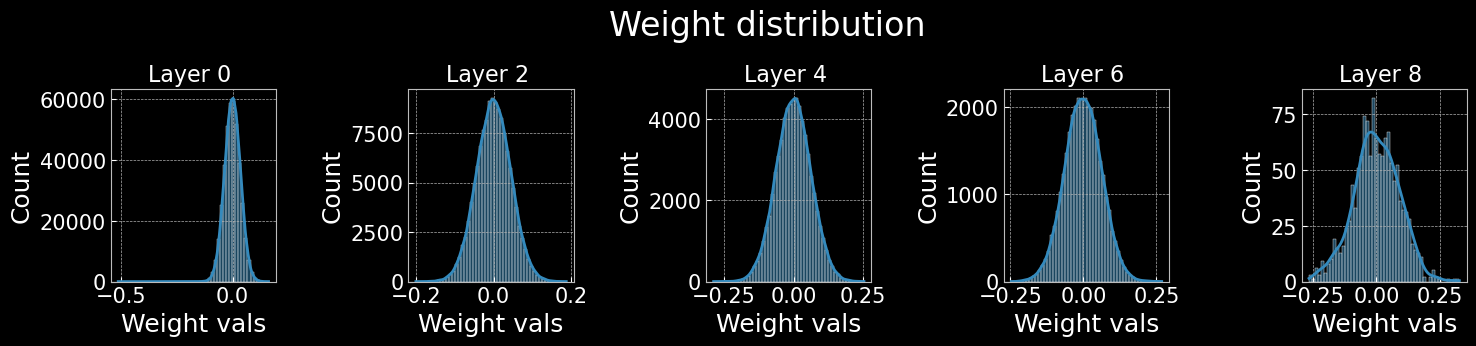

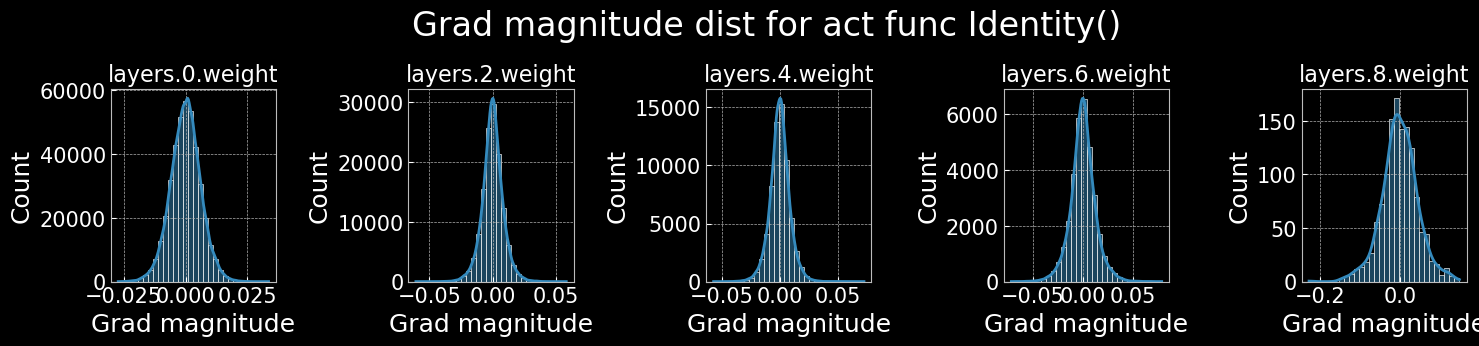

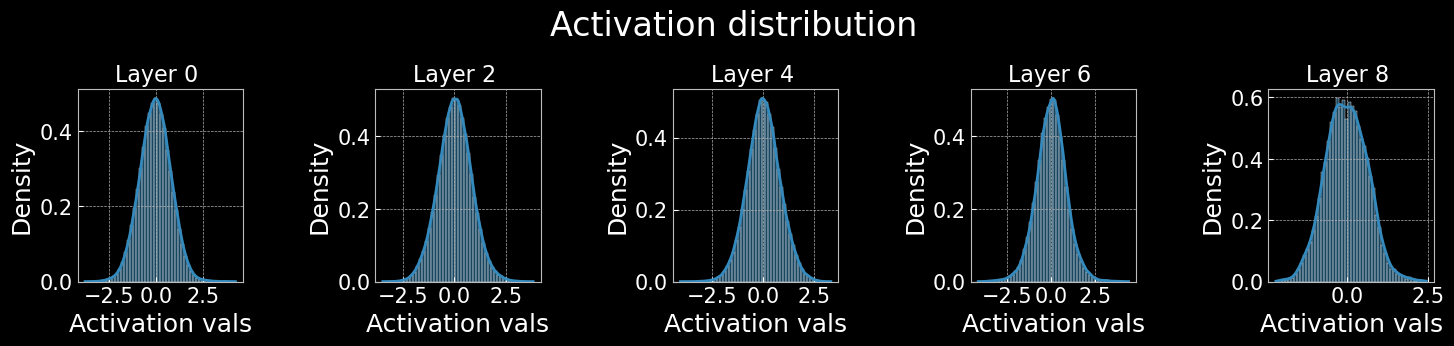

Layer 0 - Variance: 0.690331220626831
Layer 2 - Variance: 0.6664537787437439
Layer 4 - Variance: 0.6642569303512573
Layer 6 - Variance: 0.739172101020813
Layer 8 - Variance: 0.4138043522834778


In [23]:
def equal_var_init(model):
    for name, param in model.named_parameters():
        # fill bias with 0
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            param.data.normal_(std=1.0 / np.sqrt(param.shape[1]))

equal_var_init(model)
vis_weight_distribution(model)
vis_gradients(model)
vis_activations(model, print_variance=True)